# End-to-End Classification Workflow with scikit-learn

This notebook walks through a complete data science workflow on a classic classification dataset from scikit-learn:

- Problem framing and goals
- Data loading and quick EDA
- Train/validation/test split
- Baseline and multiple candidate models
- Cross-validation model comparison
- Hyperparameter tuning
- Final evaluation with ROC/PR curves and confusion matrix
- Feature importance / permutation importance
- Saving artifacts and doing a quick inference sanity check

Dataset: Breast Cancer Wisconsin (Diagnostic) — a binary classification task.


In [2]:
# Imports and setup
import os
import json
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Optional seaborn for nicer plots (gracefully degrade if missing)
try:
    import seaborn as sns
    sns.set_theme(context="notebook", style="ticks")
    HAS_SEABORN = True
except Exception:
    HAS_SEABORN = False

from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    RocCurveDisplay,
    PrecisionRecallDisplay
)
from sklearn.inspection import permutation_importance
import joblib

RNG_SEED = 42
np.random.seed(RNG_SEED)
OUTPUT_DIR = Path("artifacts")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR = Path("models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)
print(f"Environment ready. Seaborn: {HAS_SEABORN}")


Environment ready. Seaborn: True


In [3]:
# Load dataset into DataFrame
breast = datasets.load_breast_cancer()
X = pd.DataFrame(breast.data, columns=breast.feature_names)
y = pd.Series(breast.target, name="target")

print(X.shape, y.shape)
X.head(3)

(569, 30) (569,)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


Class labels: {0: np.str_('malignant'), 1: np.str_('benign')}

Basic stats:


,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.127292,3.524049,6.98100,11.70000,13.37000,15.78000,28.11000
mean texture,569.0,19.289649,4.301036,9.71000,16.17000,18.84000,21.80000,39.28000
mean perimeter,569.0,91.969033,24.298981,43.79000,75.17000,86.24000,104.10000,188.50000
mean area,569.0,654.889104,351.914129,143.50000,420.30000,551.10000,782.70000,2501.00000
mean smoothness,569.0,0.096360,0.014064,0.05263,0.08637,0.09587,0.10530,0.16340
mean compactness,569.0,0.104341,0.052813,0.01938,0.06492,0.09263,0.13040,0.34540
mean concavity,569.0,0.088799,0.079720,0.00000,0.02956,0.06154,0.13070,0.42680
mean concave points,569.0,0.048919,0.038803,0.00000,0.02031,0.03350,0.07400,0.20120
mean symmetry,569.0,0.181162,0.027414,0.10600,0.16190,0.17920,0.19570,0.30400
mean fractal dimension,569.0,0.062798,0.007060,0.04996,0.05770,0.06154,0.06612,0.09744



Class distribution (0/1):
target
0    212
1    357
Name: count, dtype: int64


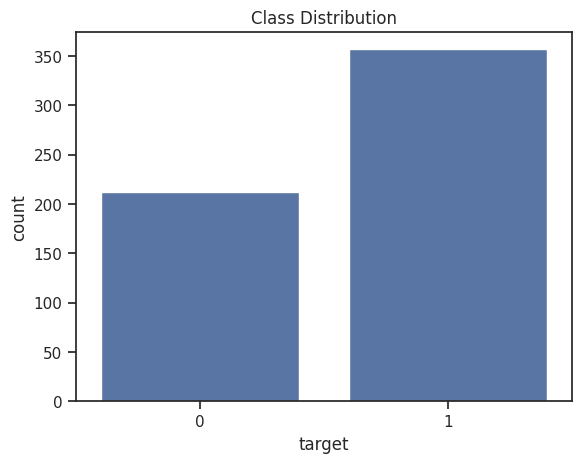

In [4]:
# Quick EDA
print("Class labels:", dict(enumerate(breast.target_names)))
print("\nBasic stats:")
display(X.describe().T.head(10))

# Class balance
class_counts = y.value_counts().sort_index()
print("\nClass distribution (0/1):")
print(class_counts)

if HAS_SEABORN:
    ax = sns.countplot(x=y)
    ax.set_title("Class Distribution")
    plt.show()
else:
    fig, ax = plt.subplots()
    ax.bar([0, 1], class_counts.values)
    ax.set_xticks([0, 1])
    ax.set_title("Class Distribution")
    plt.show()


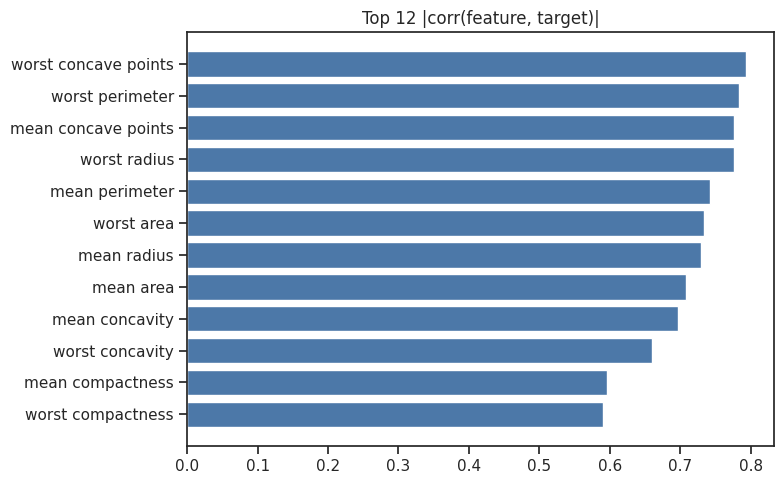

In [5]:
# Feature-to-target correlations (top 12 by absolute Pearson corr)
# For a binary target, Pearson corr gives a quick univariate signal.
correlations = {}
for col in X.columns:
    try:
        correlations[col] = np.corrcoef(X[col], y)[0, 1]
    except Exception:
        correlations[col] = np.nan
corr_s = pd.Series(correlations).abs().sort_values(ascending=False).head(12)

fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(corr_s.index[::-1], corr_s.values[::-1], color="#4C78A8")
ax.set_title("Top 12 |corr(feature, target)|")
plt.tight_layout()
plt.show()


In [6]:
# Train/Validation/Test split (hold-out test set)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RNG_SEED, stratify=y
)
X_train.shape, X_test.shape

((455, 30), (114, 30))

In [7]:
# Baseline model for reference (most frequent)
baseline = DummyClassifier(strategy="most_frequent")
baseline.fit(X_train, y_train)
y_pred_base = baseline.predict(X_test)
print("Baseline accuracy:", accuracy_score(y_test, y_pred_base))
print(classification_report(y_test, y_pred_base))

Baseline accuracy: 0.631578947368421
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.63      1.00      0.77        72

    accuracy                           0.63       114
   macro avg       0.32      0.50      0.39       114
weighted avg       0.40      0.63      0.49       114



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [8]:
# Candidate models wrapped in pipelines (with scaling)
preprocess = StandardScaler()

candidates = {
    "logreg": make_pipeline(preprocess, LogisticRegression(max_iter=500)),
    "random_forest": make_pipeline(preprocess, RandomForestClassifier(random_state=RNG_SEED)),
    "gradient_boosting": make_pipeline(preprocess, GradientBoostingClassifier(random_state=RNG_SEED)),
    "svc": make_pipeline(preprocess, SVC(probability=True))
}
list(candidates.keys())

['logreg', 'random_forest', 'gradient_boosting', 'svc']

In [9]:
# Cross-validate candidates and compare
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG_SEED)
scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc",
}

cv_results = {}
for name, est in candidates.items():
    scores = cross_validate(est, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    cv_results[name] = {k: np.mean(v) for k, v in scores.items() if k.startswith("test_")}

cv_df = pd.DataFrame(cv_results).T.sort_values("test_roc_auc", ascending=False)
cv_df

,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
logreg,0.978022,0.979472,0.985965,0.982544,0.995872
svc,0.969231,0.972750,0.978947,0.975615,0.995562
gradient_boosting,0.951648,0.961725,0.961404,0.961363,0.991847
random_forest,0.962637,0.975519,0.964912,0.969935,0.989577


In [10]:
# Select best model by ROC AUC
best_name = cv_df.index[0]
best_base_est = candidates[best_name]
print("Best candidate (ROC AUC):", best_name)
best_base_est

Best candidate (ROC AUC): logreg


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=500))])

In [11]:
# Hyperparameter tuning for the selected model
param_grids = {
    "logreg": {
        "logisticregression__C": [0.1, 1.0, 10.0],
        "logisticregression__solver": ["lbfgs", "liblinear"],
        "logisticregression__penalty": ["l2"],
    },
    "random_forest": {
        "randomforestclassifier__n_estimators": [150, 300],
        "randomforestclassifier__max_depth": [None, 5, 10],
        "randomforestclassifier__min_samples_split": [2, 5],
    },
    "gradient_boosting": {
        "gradientboostingclassifier__n_estimators": [100, 200],
        "gradientboostingclassifier__learning_rate": [0.05, 0.1, 0.2],
        "gradientboostingclassifier__max_depth": [2, 3],
    },
    "svc": {
        "svc__C": [0.5, 1.0, 5.0],
        "svc__gamma": ["scale", "auto"],
        "svc__kernel": ["rbf"],
    },
}

param_grid = param_grids[best_name]
print(f"Tuning grid for {best_name} with {len(next(iter(param_grid.values())))} to {sum(len(v) for v in param_grid.values())} total options across dims.")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG_SEED)
gs = GridSearchCV(best_base_est, param_grid=param_grid, scoring="roc_auc", cv=cv, n_jobs=-1, refit=True, verbose=0)
start = time.time()
gs.fit(X_train, y_train)
print(f"GridSearchCV done in {time.time()-start:.2f}s")
print("Best params:", gs.best_params_)
print("Best CV ROC AUC:", gs.best_score_)

best_model = gs.best_estimator_


Tuning grid for logreg with 3 to 6 total options across dims.
GridSearchCV done in 0.46s
Best params: {'logisticregression__C': 1.0, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
Best CV ROC AUC: 0.9959752321981423
GridSearchCV done in 0.46s
Best params: {'logisticregression__C': 1.0, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
Best CV ROC AUC: 0.9959752321981423


{
  "accuracy": 0.9824561403508771,
  "precision": 0.9861111111111112,
  "recall": 0.9861111111111112,
  "f1": 0.9861111111111112,
  "roc_auc": 0.9957010582010581
}

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



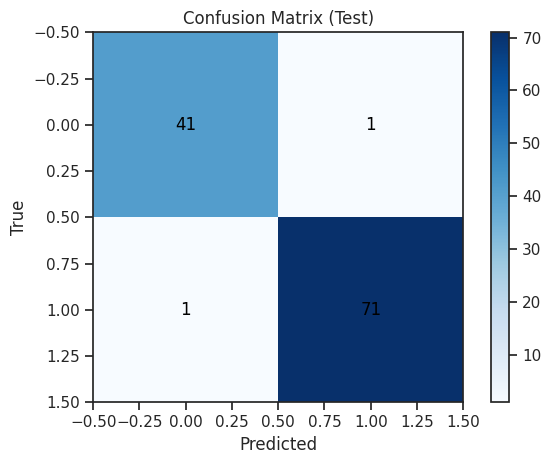

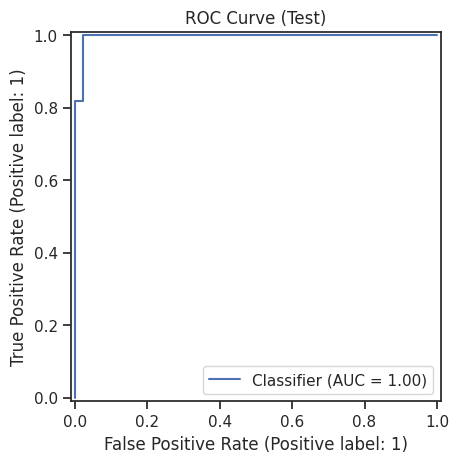

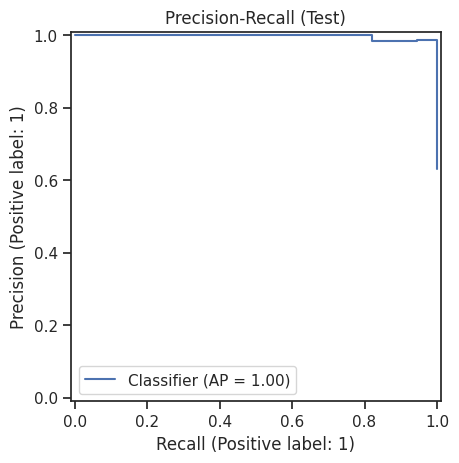

In [12]:
# Final evaluation on the test set
# Probabilities for ROC/PR
if hasattr(best_model, "predict_proba"):
    y_proba = best_model.predict_proba(X_test)[:, 1]
elif hasattr(best_model, "decision_function"):
    y_proba = best_model.decision_function(X_test)
else:
    # Fallback; some metrics won't be available
    y_proba = best_model.predict(X_test)

y_pred = (y_proba >= 0.5).astype(int) if y_proba.ndim == 1 else best_model.predict(X_test)

metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, zero_division=0),
    "recall": recall_score(y_test, y_pred, zero_division=0),
    "f1": f1_score(y_test, y_pred, zero_division=0),
}
try:
    metrics["roc_auc"] = roc_auc_score(y_test, y_proba)
except Exception:
    pass

print(json.dumps(metrics, indent=2))
print("\nClassification report:\n", classification_report(y_test, y_pred))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap="Blues")
ax.set_title("Confusion Matrix (Test)")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black")
plt.colorbar(im)
plt.tight_layout()
plt.show()

# ROC & PR curves
try:
    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title("ROC Curve (Test)")
    plt.show()
    PrecisionRecallDisplay.from_predictions(y_test, y_proba)
    plt.title("Precision-Recall (Test)")
    plt.show()
except Exception as e:
    print("Skipping ROC/PR plots:", e)


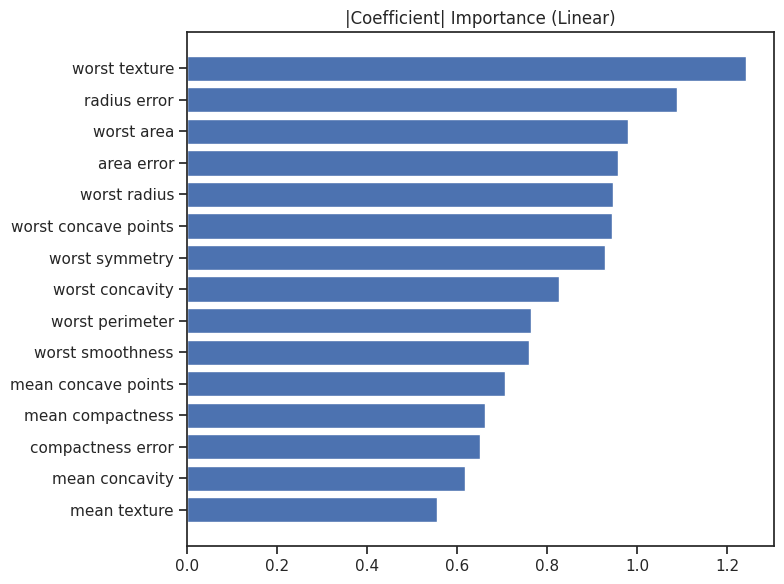

In [13]:
# Feature importance or permutation importance
feature_names = X.columns

def plot_feature_importances(names, values, title="Feature Importance", top_n=15):
    order = np.argsort(values)[-top_n:]
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.barh(np.array(names)[order], np.array(values)[order])
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

# Try model-native importances
importances_plotted = False
try:
    # If tree-based
    if hasattr(best_model[-1], "feature_importances_"):
        importances = best_model[-1].feature_importances_
        plot_feature_importances(feature_names, importances, title="Tree-based Feature Importance")
        importances_plotted = True
    # If linear model
    elif hasattr(best_model[-1], "coef_"):
        coefs = np.ravel(best_model[-1].coef_)
        plot_feature_importances(feature_names, np.abs(coefs), title="|Coefficient| Importance (Linear)")
        importances_plotted = True
except Exception as e:
    print("Native importance not available:", e)

if not importances_plotted:
    print("Using permutation importance on the test set (may take a moment)...")
    pi = permutation_importance(best_model, X_test, y_test, scoring="roc_auc", n_repeats=10, random_state=RNG_SEED)
    plot_feature_importances(feature_names, pi.importances_mean, title="Permutation Importance (Test)")


In [16]:
# Save artifacts (model + metrics)
model_path = MODELS_DIR / f"best_model_{best_name}.joblib"
metrics_path = OUTPUT_DIR / "test_metrics.json"

joblib.dump(best_model, model_path)
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved:")
print(" -", model_path)
print(" -", metrics_path)

Saved:
 - models/best_model_logreg.joblib
 - artifacts/test_metrics.json


In [15]:
# Quick inference sanity check
loaded = joblib.load(model_path)
sample = X_test.sample(1, random_state=RNG_SEED)
pred_prob = None
if hasattr(loaded, "predict_proba"):
    pred_prob = loaded.predict_proba(sample)[:, 1][0]
pred = loaded.predict(sample)[0]
print("Sample prediction:", pred, "with P(positive)=", pred_prob)
print("True label:", y_test.loc[sample.index].values[0])

Sample prediction: 1 with P(positive)= 0.8594769079898834
True label: 1


## Conclusion

- We built baselines and multiple candidate models with pipelines.
- Cross-validation selected the best candidate by ROC AUC.
- A small GridSearchCV improved performance.
- Final test metrics, ROC/PR curves, and a confusion matrix were produced.
- We examined feature importance and saved artifacts for reuse.

You can adapt this template to other scikit-learn datasets or your own CSV by replacing the data-loading section and possibly adding preprocessing with ColumnTransformer for mixed feature types.
